In [9]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import json
import os
import collections

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import itertools
from itertools import combinations 


import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler 

from sklearn import metrics
 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import DataLoader as DataLoaderGraph
from torch_geometric.data import Dataset as DatasetGraph
from torch_geometric.data import Batch as BatchGraph

#from torch_geometric.transforms import AddTrainValTestMask as masking

from torch_geometric.nn import GCNConv, BatchNorm, SAGEConv, SGConv, ChebConv
from torch_geometric.utils.convert import to_networkx

import networkx as nx

In [10]:
with open("musae_git_features.json") as json_data:
    data_raw = json.load(json_data)

edges=pd.read_csv("musae_git_edges.csv")
target_df=pd.read_csv("musae_git_target.csv")#.to_numpy()[:,2]

In [11]:
print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


In [12]:
feats=[]
feat_counts=[]
for i in range(len(data_raw)):
    feat_counts+=[len(data_raw[str(i)])]
    feats+=data_raw[str(i)]

print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


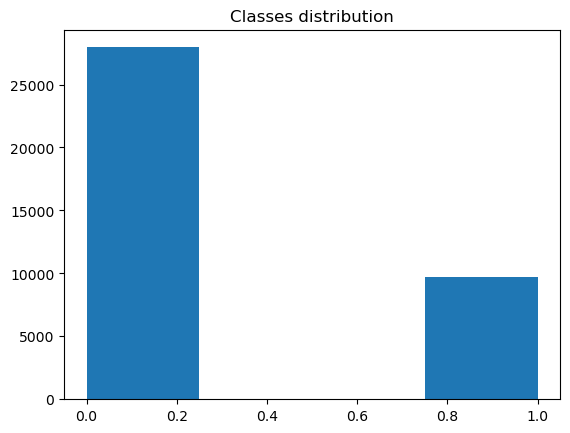

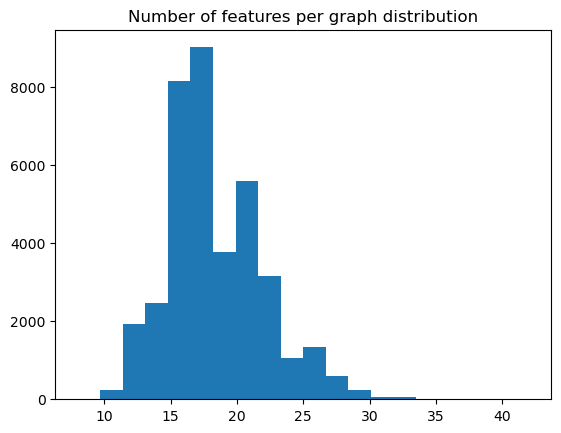

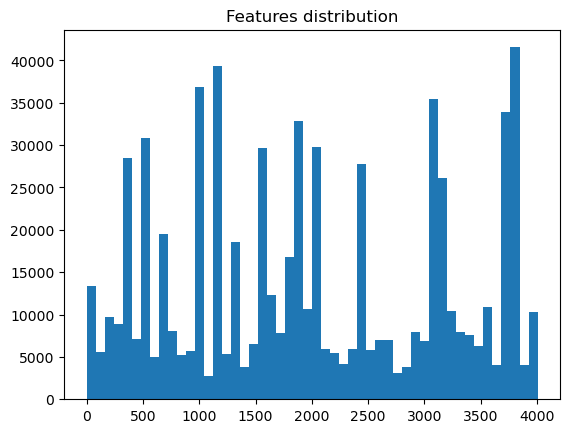

In [13]:
plt.hist(target_df.ml_target,bins=4,);
plt.title("Classes distribution")
plt.show()

plt.hist(feat_counts,bins=20)
plt.title("Number of features per graph distribution")
plt.show()

plt.hist(feats,bins=50)
plt.title("Features distribution")
plt.show()

In [14]:
counter=collections.Counter(feats)
print(list(counter.keys())[:10])
print(list(counter.values())[:10])
print(list(counter.keys())[-10:])
print(list(counter.values())[-10:])

[1574, 3773, 3571, 2672, 2478, 2534, 3129, 3077, 1171, 2045]
[5045, 12726, 2486, 298, 165, 510, 22075, 28188, 24958, 21449]
[936, 172, 875, 3548, 2745, 793, 1941, 464, 2616, 3124]
[1, 2, 1, 2, 1, 1, 1, 1, 1, 1]


In [15]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)
    
    data_encoded={}
    for i in range(nodes_included):# 
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)
    
    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

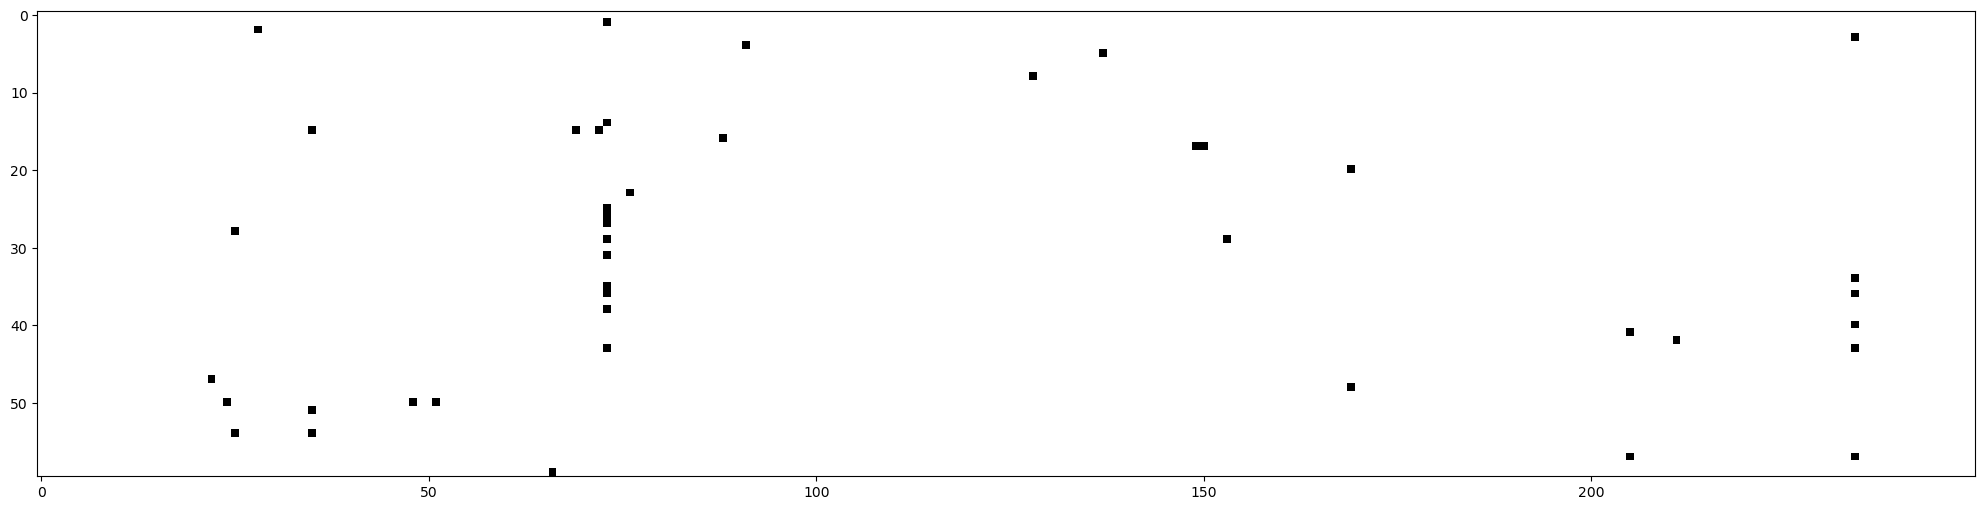

In [16]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
plt.figure(figsize=(25,25));
plt.imshow(sparse_feat_matrix_vis[:,:250],cmap='Greys');
#plt.grid()

In [17]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    node_labels=torch.tensor(target_df['ml_target'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

In [18]:
#g_top_draw = Data(x=node_features, y=node_labels, edge_index=edge_index0)

def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return
        
    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color =node_colors,node_size=600,connectionstyle="angle3",
                width =1, with_labels = False, edge_color = 'k', arrowstyle = "-")

Data(x=[37700, 4005], edge_index=[2, 578006], y=[37700])


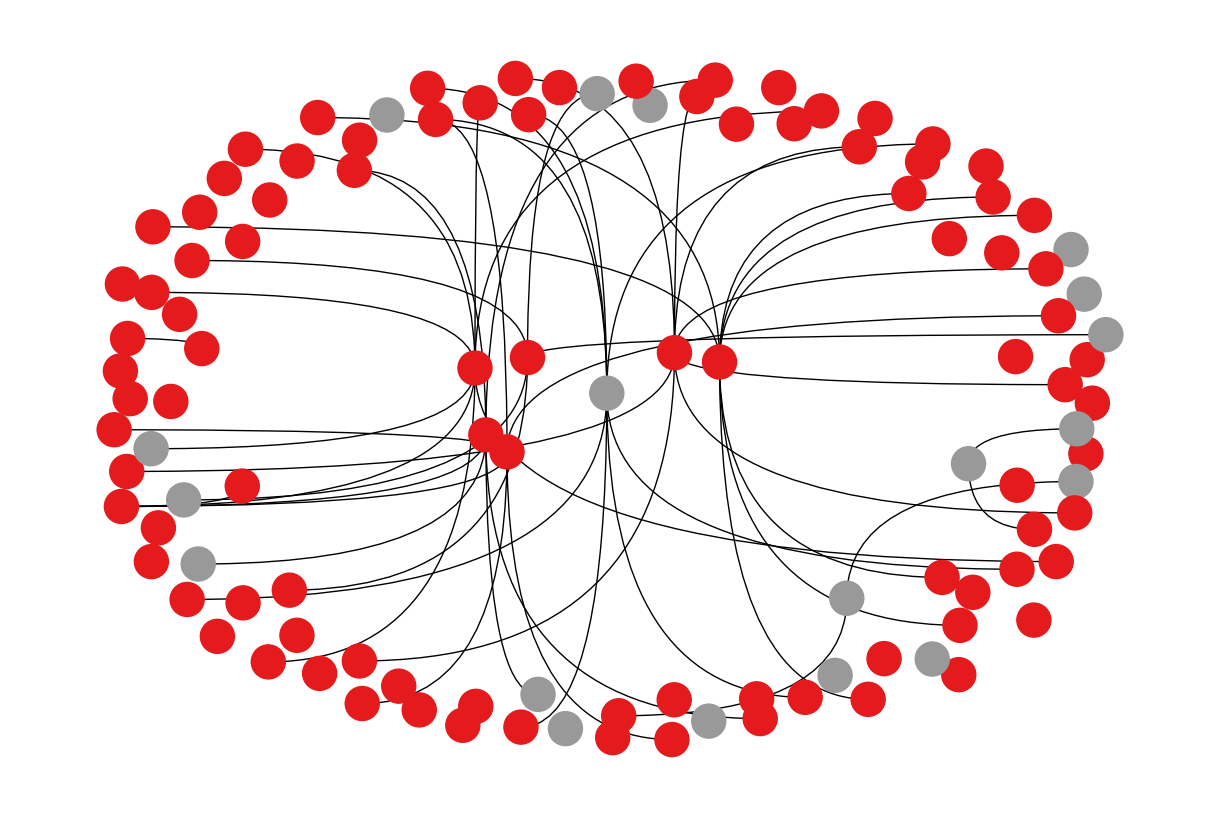

In [19]:
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)
draw_graph(g_sample)
data_encoded,_=encode_data(light=False)
g=construct_graph(data_encoded=data_encoded,light=False)
print(g)

In [20]:
import torch_geometric.transforms as T
msk=T.RandomNodeSplit(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0.6)
g=msk(g)
print(g)
print()
print("training samples",torch.sum(g.train_mask).item())
print("validation samples",torch.sum(g.val_mask ).item())
print("test samples",torch.sum(g.test_mask ).item())

Data(x=[37700, 4005], edge_index=[2, 578006], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])

training samples 3770
validation samples 11310
test samples 22620


In [21]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)  

In [22]:
def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy) 

In [23]:
def train_social(net,data,epochs=10,lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 00001
    best_accuracy=0.0
    
    train_losses=[]
    train_accuracies=[]

    val_losses=[]
    val_accuracies=[]

    test_losses=[]
    test_accuracies=[]
    
    for ep in range(epochs+1):
        optimizer.zero_grad()
        out=net(data)
        loss=masked_loss(predictions=out,
                         labels=data.y,
                         mask=data.train_mask)
        loss.backward()
        optimizer.step()
        train_losses+=[loss]
        train_accuracy=masked_accuracy(predictions=out,
                                       labels=data.y, 
                                       mask=data.train_mask)
        train_accuracies+=[train_accuracy]
        
        val_loss=masked_loss(predictions=out,
                             labels=data.y, 
                             mask=data.val_mask)
        val_losses+=[val_loss]
        
        val_accuracy=masked_accuracy(predictions=out,
                                     labels=data.y, 
                                     mask=data.val_mask)
        val_accuracies+=[val_accuracy]

        test_accuracy=masked_accuracy(predictions=out,
                                      labels=data.y, 
                                      mask=data.test_mask)
        test_accuracies+=[test_accuracy]
        if np.round(val_accuracy,4)> np.round(best_accuracy ,4):
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                      .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            best_accuracy=val_accuracy

  

    
    plt.plot(train_accuracies) 
    plt.plot(val_accuracies)
    plt.plot(test_accuracies) 
    plt.show()
    
    print("Best accuracy",best_accuracy) 
    return(best_accuracy)

## GAT

In [24]:
from torch_geometric.nn import GATConv

class GATNet(torch.nn.Module):
    def __init__(self, num_features, hidden_units):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(num_features, hidden_units, heads=4, dropout=0.2)
        # After concatenating the heads, hidden_units*4 will be the size
        self.conv2 = GATConv(hidden_units*4, 2, heads=1, concat=False, dropout=0.2)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

Epoch 1/20, Train_Loss: 0.6737, Train_Accuracy: 0.7355, Val_Accuracy: 0.7254, Test_Accuracy: 0.7191
Epoch 2/20, Train_Loss: 4.0089, Train_Accuracy: 0.7509, Val_Accuracy: 0.7438, Test_Accuracy: 0.7392
Epoch 4/20, Train_Loss: 1.6291, Train_Accuracy: 0.7565, Val_Accuracy: 0.7490, Test_Accuracy: 0.7442
Epoch 5/20, Train_Loss: 2.3945, Train_Accuracy: 0.7576, Val_Accuracy: 0.7499, Test_Accuracy: 0.7448
Epoch 6/20, Train_Loss: 1.8554, Train_Accuracy: 0.7796, Val_Accuracy: 0.7744, Test_Accuracy: 0.7699
Epoch 7/20, Train_Loss: 0.8826, Train_Accuracy: 0.8369, Val_Accuracy: 0.8286, Test_Accuracy: 0.8302
Epoch 11/20, Train_Loss: 0.5793, Train_Accuracy: 0.8485, Val_Accuracy: 0.8454, Test_Accuracy: 0.8424


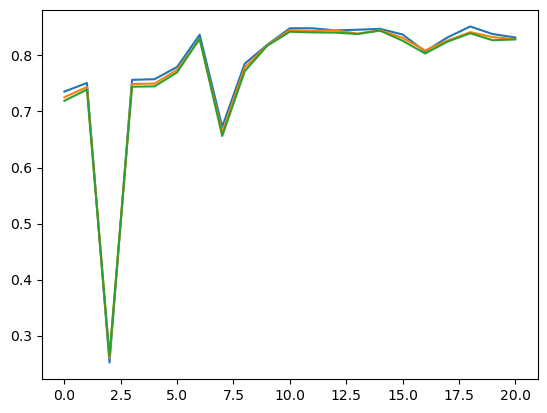

Best accuracy tensor(0.8454)


tensor(0.8454)

In [25]:
num_of_features=g.num_node_features
hidden_units = 16
net=GATNet(num_features=num_of_features,hidden_units=hidden_units)
criterion=nn.CrossEntropyLoss()
train_social(net,g,epochs=20,lr=0.1)

Mean Squared Error (MSE): 0.1400972590627763
F1 Score: 0.789671448882378
ROC-AUC Score: 0.8995326413105181


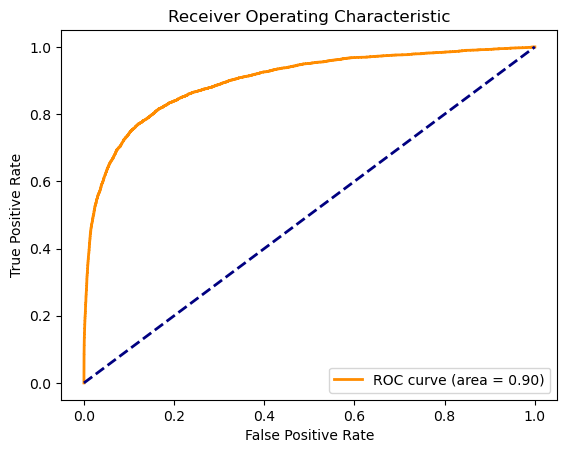

In [26]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model and data are on the correct device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
g = g.to(device)

# Function to evaluate the model on the test set
def evaluate_model(net, data, mask):
    net.eval()
    with torch.no_grad():
        out = net(data)
    return out[mask], data.y[mask]

# Function to calculate MSE, F1-score, and ROC-AUC
def evaluate_metrics(predictions, labels):
    softmax_outputs = torch.exp(predictions)  # convert logits to probabilities
    test_softmax = softmax_outputs.cpu().detach().numpy()
    test_labels = labels.cpu().numpy()
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(np.argmax(test_softmax, axis=1), test_labels)
    print("Mean Squared Error (MSE):", mse)
    
    # Calculate F1-score
    f1 = f1_score(test_labels, np.argmax(test_softmax, axis=1), average='macro')
    print("F1 Score:", f1)
    
    # Calculate ROC-AUC for binary or multi-class by treating it as One-vs-Rest
    if test_softmax.shape[1] == 2:  # Binary classification special case
        roc_auc = roc_auc_score(test_labels, test_softmax[:, 1])
    else:
        test_labels = label_binarize(test_labels, classes=np.unique(test_labels))
        roc_auc = roc_auc_score(test_labels, test_softmax, multi_class='ovr')
    print("ROC-AUC Score:", roc_auc)
    
    # Optional: Plot ROC Curve for binary classification
    if test_softmax.shape[1] == 2:
        fpr, tpr, _ = roc_curve(test_labels, test_softmax[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

# Evaluate the model on the test set
test_predictions, test_labels = evaluate_model(net, g, g.test_mask)
evaluate_metrics(test_predictions, test_labels)


## MPNN

In [27]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops, degree

class BasicMPNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(BasicMPNN, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
    
    # Convert x to float
        x = x.float()  # Ensure x is a floating-point tensor
    
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)

        # Start propagating messages.
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j, edge_index, size):
        # Compute normalization.
        row, col = edge_index
        deg = degree(col, size[1], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return norm.view(-1, 1) * x_j

model = BasicMPNN(in_channels=g.num_node_features, out_channels=64)


Epoch 1/20, Train_Loss: 2.7665, Train_Accuracy: 0.0387, Val_Accuracy: 0.0437, Test_Accuracy: 0.0395
Epoch 2/20, Train_Loss: 1.2287, Train_Accuracy: 0.7531, Val_Accuracy: 0.7422, Test_Accuracy: 0.7395
Epoch 3/20, Train_Loss: 0.7021, Train_Accuracy: 0.7538, Val_Accuracy: 0.7475, Test_Accuracy: 0.7421
Epoch 4/20, Train_Loss: 0.5442, Train_Accuracy: 0.7663, Val_Accuracy: 0.7595, Test_Accuracy: 0.7552
Epoch 5/20, Train_Loss: 0.4654, Train_Accuracy: 0.8053, Val_Accuracy: 0.7955, Test_Accuracy: 0.7970
Epoch 6/20, Train_Loss: 0.4063, Train_Accuracy: 0.8459, Val_Accuracy: 0.8389, Test_Accuracy: 0.8385
Epoch 7/20, Train_Loss: 0.3717, Train_Accuracy: 0.8650, Val_Accuracy: 0.8612, Test_Accuracy: 0.8588
Epoch 8/20, Train_Loss: 0.3603, Train_Accuracy: 0.8666, Val_Accuracy: 0.8687, Test_Accuracy: 0.8644
Epoch 9/20, Train_Loss: 0.3599, Train_Accuracy: 0.8679, Val_Accuracy: 0.8699, Test_Accuracy: 0.8649
Epoch 10/20, Train_Loss: 0.3592, Train_Accuracy: 0.8682, Val_Accuracy: 0.8714, Test_Accuracy: 0.8657

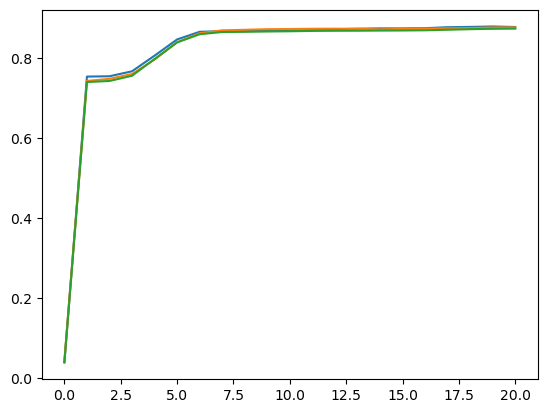

Best accuracy tensor(0.8760)


tensor(0.8760)

In [28]:
num_node_features = g.num_node_features  # Correct variable name for clarity
out_channels = 16  # Specifies the desired number of output features

net = BasicMPNN(in_channels=num_node_features, out_channels=out_channels)
criterion = nn.CrossEntropyLoss()

# Assuming 'train_social' is your function for training, which should now work correctly.
train_social(net, g, epochs=20, lr=0.1)


Mean Squared Error (MSE): 0.2608311229000884
F1 Score: 0.42501270971021865
ROC-AUC Score: 0.453479259589652


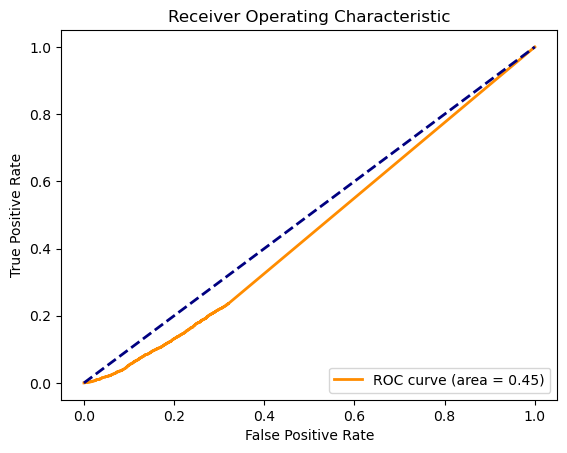

In [29]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
g = g.to(device)

# Function to evaluate the model on the test set
def evaluate_model(net, data, mask):
    net.eval()
    with torch.no_grad():
        logits = net(data)
    return logits[mask], data.y[mask]

# Function to calculate MSE, F1-score, and ROC-AUC
def evaluate_metrics(logits, labels):
    # Assuming logits are not directly probabilities
    # Summing all logits to use as a score for positive class
    scores = logits.sum(dim=1)
    probs = torch.sigmoid(scores)  # Convert scores to probabilities

    # Convert to numpy arrays for sklearn compatibility
    probs_np = probs.cpu().detach().numpy()
    labels_np = labels.cpu().detach().numpy()

    # Calculate Mean Squared Error (MSE)
    predicted_classes = (probs_np > 0.5).astype(int)
    mse = mean_squared_error(predicted_classes, labels_np)
    print("Mean Squared Error (MSE):", mse)
    
    # Calculate F1-score
    f1 = f1_score(labels_np, predicted_classes, average='macro')
    print("F1 Score:", f1)
    
    # ROC-AUC for binary classification
    roc_auc = roc_auc_score(labels_np, probs_np)
    print("ROC-AUC Score:", roc_auc)
    
    # Plot ROC Curve for binary classification
    fpr, tpr, _ = roc_curve(labels_np, probs_np)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate the model on the test set
test_logits, test_labels = evaluate_model(net, g, g.test_mask)
evaluate_metrics(test_logits, test_labels)


## GCN

In [30]:
class SocialGNN(torch.nn.Module):
    def __init__(self,num_of_feat,f):
        super(SocialGNN, self).__init__()


        self.conv1 = GCNConv(num_of_feat, f)

        self.conv2 = GCNConv(f, 2)


    def forward(self, data):
        x = data.x.float()
        edge_index =  data.edge_index
          
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        return x

Epoch 1/20, Train_Loss: 0.6897, Train_Accuracy: 0.7050, Val_Accuracy: 0.6914, Test_Accuracy: 0.6905
Epoch 2/20, Train_Loss: 1.3877, Train_Accuracy: 0.7509, Val_Accuracy: 0.7438, Test_Accuracy: 0.7392
Epoch 3/20, Train_Loss: 0.5588, Train_Accuracy: 0.7512, Val_Accuracy: 0.7442, Test_Accuracy: 0.7396
Epoch 4/20, Train_Loss: 0.4716, Train_Accuracy: 0.7520, Val_Accuracy: 0.7453, Test_Accuracy: 0.7405
Epoch 5/20, Train_Loss: 0.5385, Train_Accuracy: 0.7541, Val_Accuracy: 0.7490, Test_Accuracy: 0.7435
Epoch 6/20, Train_Loss: 0.5335, Train_Accuracy: 0.7639, Val_Accuracy: 0.7592, Test_Accuracy: 0.7534
Epoch 7/20, Train_Loss: 0.4847, Train_Accuracy: 0.8011, Val_Accuracy: 0.7912, Test_Accuracy: 0.7880
Epoch 8/20, Train_Loss: 0.4161, Train_Accuracy: 0.8401, Val_Accuracy: 0.8347, Test_Accuracy: 0.8369
Epoch 9/20, Train_Loss: 0.3627, Train_Accuracy: 0.8607, Val_Accuracy: 0.8618, Test_Accuracy: 0.8595
Epoch 10/20, Train_Loss: 0.3612, Train_Accuracy: 0.8621, Val_Accuracy: 0.8662, Test_Accuracy: 0.8618

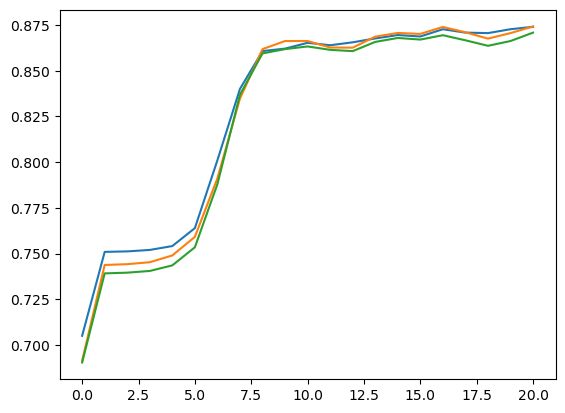

Best accuracy tensor(0.8742)


tensor(0.8742)

In [31]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
criterion=nn.CrossEntropyLoss()
train_social(net,g,epochs=20,lr=0.1)

Mean Squared Error (MSE): 0.127763041556145
F1 Score: 0.8239105014816486
ROC-AUC Score: 0.9127138056524207


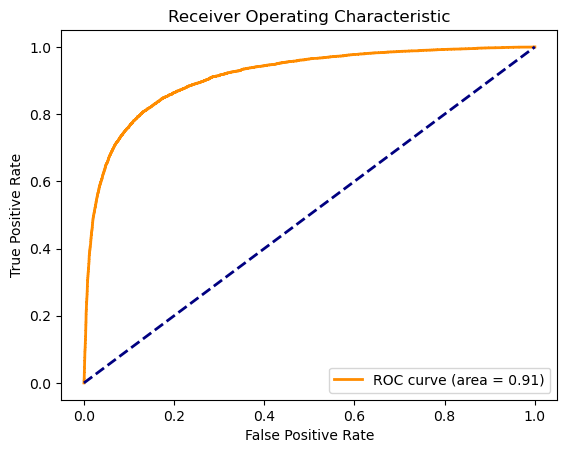

In [32]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
g = g.to(device)

def evaluate_model(net, data, mask):
    net.eval()
    with torch.no_grad():
        out = net(data)
    return out[mask], data.y[mask]

def evaluate_metrics(predictions, labels):
    softmax_outputs = torch.exp(predictions)
    test_softmax = softmax_outputs.cpu().detach().numpy()
    test_labels = labels.cpu().numpy()
    
    mse = mean_squared_error(np.argmax(test_softmax, axis=1), test_labels)
    print("Mean Squared Error (MSE):", mse)
    
    f1 = f1_score(test_labels, np.argmax(test_softmax, axis=1), average='macro')
    print("F1 Score:", f1)
    
    if test_softmax.shape[1] == 2:
        roc_auc = roc_auc_score(test_labels, test_softmax[:, 1])
    else:
        test_labels = label_binarize(test_labels, classes=np.unique(test_labels))
        roc_auc = roc_auc_score(test_labels, test_softmax, multi_class='ovr')
    print("ROC-AUC Score:", roc_auc)
    
    if test_softmax.shape[1] == 2:
        fpr, tpr, _ = roc_curve(test_labels, test_softmax[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

test_predictions, test_labels = evaluate_model(net, g, g.test_mask)
evaluate_metrics(test_predictions, test_labels)
